In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import TensorDataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
# Read in the data from the file
with open('amazon_cells_labelled.txt', 'r') as file:
    lines = file.readlines()

# Remove any leading/trailing whitespace like \n
sentences = [line.strip() for line in lines]

# Separate sentences and their labels (0 = negative, 1 = positive)
sentiment_labels = [int(line.strip().split('\t')[1]) for line in lines]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the sentences into a document-term matrix (tokens)
X = vectorizer.fit_transform(sentences)

# Convert the result to an array
X_array = X.toarray()

# Tokenized sentences
tokens = [sentence.split() for sentence in sentences]


In [4]:
# Analyze sentence lengths and the presence of unusual characters
unusual_chars_count = sum([any(ord(c) > 127 for c in sentence) for sentence in sentences])
vocabulary_size = len(set([word for sentence in tokens for word in sentence]))

# Find the sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in sentences]
average_sentence_length = np.mean(sentence_lengths)
percentile_95_length = np.percentile(sentence_lengths, 95)

# Print out the results
print(f"Number of sentences with unusual characters: {unusual_chars_count}")
print(f"Vocabulary size: {vocabulary_size}")
print(f"Average sentence length: {average_sentence_length:.2f} words")
print(f"95th percentile sentence length: {percentile_95_length} words")

Number of sentences with unusual characters: 0
Vocabulary size: 2816
Average sentence length: 11.25 words
95th percentile sentence length: 24.0 words


In [5]:
# Download NLTK data if not already installed
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/rowanzinn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
def pad_sequences_custom(sequences, maxlen=None, padding='post', truncating='post', value=0):
    """
    Pad sequences to the same length without using TensorFlow/Keras.
    """
    if not maxlen:
        maxlen = max(len(seq) for seq in sequences)
    
    padded_sequences = np.full((len(sequences), maxlen), value)

    for idx, seq in enumerate(sequences):
        if truncating == 'pre':
            trunc = seq[-maxlen:]
        else:
            trunc = seq[:maxlen]
        
        if padding == 'post':
            padded_sequences[idx, :len(trunc)] = trunc
        else:
            padded_sequences[idx, -len(trunc):] = trunc

    return padded_sequences

In [7]:
# Tokenize the sentences
tokens = [sentence.lower().split() for sentence in sentences]

# Build the vocabulary
vectorizer = CountVectorizer()
vectorizer.fit(sentences)
word_index = vectorizer.vocabulary_

# Convert tokens to sequences (safely)
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in tokens]

# Set maximum sequence length (based on earlier EDA)
max_len = 24

# Pad sequences (using custom function, not keras)
padded_sequences = pad_sequences_custom(sequences, maxlen=max_len, padding='post', truncating='post')

# Check one padded sequence
print(padded_sequences[0])


[1491 1609  854 1074 1766  653  993 1640 1212  857  814  762  814 1604
 1714 1702  711  233    0    0    0    0    0    0]


In [8]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, sentiment_labels, test_size=0.2, random_state=42)

# Further split the test set into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Check the size of splits
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 800
Validation set size: 100
Test set size: 100


In [9]:
# Saving the test and train 
# Since they are padded sequences (nested lists)
train_df = pd.DataFrame({'sentence': [' '.join(map(str, seq)) for seq in X_train], 'label': y_train})
test_df = pd.DataFrame({'sentence': [' '.join(map(str, seq)) for seq in X_test], 'label': y_test})

# Save to CSV
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [10]:
# Define the model
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SentimentNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure input is LongTensor before passing it to the embedding layer
        x = x.long()  # Convert input to LongTensor if necessary
        
        x = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        x = x.mean(dim=1)  # Average embeddings: shape (batch_size, embed_dim)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid to output
        return x

In [11]:
# Initialize the Model
vocab_size = 2816  # Just an example, replace it with your actual vocabulary size
embed_dim = 50      # Size of word embeddings
hidden_dim = 64     # Size of the hidden layer in the fully connected layer
output_dim = 1  # For binary classification

# Create the model instance
model = SentimentNet(vocab_size, embed_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
def calculate_accuracy(predictions, labels):
    predicted_classes = (predictions > 0.5).float()  # Assuming binary classification
    correct = (predicted_classes == labels).float()
    accuracy = correct.sum() / len(correct)  # Accuracy as the percentage of correct predictions
    return accuracy.item()

In [14]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

# Parameters
num_epochs = 20
batch_size = 10

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create validation DataLoader
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train_losses = []
val_losses = []
train_accuracies = []  # To store training accuracy for each epoch
val_accuracies = []  # To store validation accuracy for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Iterate through batches in the training DataLoader
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        # Ensure batch_y has the same shape as the output
        batch_y = batch_y.unsqueeze(1)  # This adds the missing dimension

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy for the batch
        accuracy = calculate_accuracy(outputs, batch_y)
        running_accuracy += accuracy

        # Print batch loss and accuracy info
        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    avg_train_loss = running_loss / len(train_loader)  # Average over the number of batches
    avg_train_accuracy = running_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)  # Save the average accuracy for the epoch
    print(f"Average Training Loss (epoch {epoch+1}): {avg_train_loss:.4f}, Average Accuracy: {avg_train_accuracy:.4f}")
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    running_val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.unsqueeze(1)  # Make sure labels match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy for the batch
            accuracy = calculate_accuracy(outputs, labels)
            running_val_accuracy += accuracy

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_accuracy = running_val_accuracy / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)  # Save the average validation accuracy for the epoch
    print(f"Average Validation Loss (epoch {epoch+1}): {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}\n")


/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_31515/1896483038.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long)
/var/folders/cn/5rls9kg91b35jqphwksc14700000gn/T/ipykernel_31515/1896483038.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float)


Epoch 1/20
Batch 1/80, Loss: 0.6822, Accuracy: 0.7000
Batch 2/80, Loss: 0.6975, Accuracy: 0.4000
Batch 3/80, Loss: 0.6718, Accuracy: 0.7000
Batch 4/80, Loss: 0.7157, Accuracy: 0.4000
Batch 5/80, Loss: 0.6916, Accuracy: 0.6000
Batch 6/80, Loss: 0.6765, Accuracy: 0.5000
Batch 7/80, Loss: 0.7092, Accuracy: 0.5000
Batch 8/80, Loss: 0.7110, Accuracy: 0.5000
Batch 9/80, Loss: 0.6728, Accuracy: 0.6000
Batch 10/80, Loss: 0.6706, Accuracy: 0.6000
Batch 11/80, Loss: 0.7578, Accuracy: 0.3000
Batch 12/80, Loss: 0.6921, Accuracy: 0.5000
Batch 13/80, Loss: 0.6911, Accuracy: 0.5000
Batch 14/80, Loss: 0.6566, Accuracy: 0.7000
Batch 15/80, Loss: 0.6906, Accuracy: 0.6000
Batch 16/80, Loss: 0.7082, Accuracy: 0.4000
Batch 17/80, Loss: 0.6753, Accuracy: 0.7000
Batch 18/80, Loss: 0.6716, Accuracy: 0.8000
Batch 19/80, Loss: 0.7006, Accuracy: 0.4000
Batch 20/80, Loss: 0.6858, Accuracy: 0.5000
Batch 21/80, Loss: 0.7045, Accuracy: 0.5000
Batch 22/80, Loss: 0.6933, Accuracy: 0.5000
Batch 23/80, Loss: 0.6961, Acc

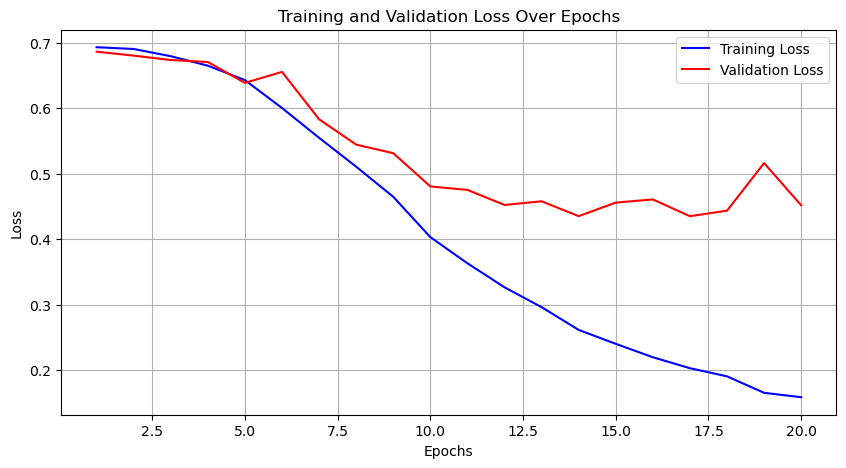

In [15]:
# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

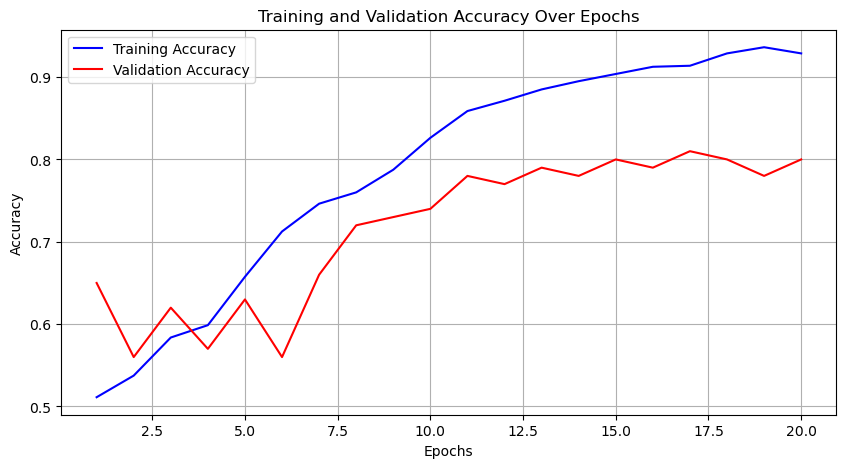

In [16]:
# Plotting Accuracy (Assuming you have accuracy recorded during training)
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Save the trained model
model_save_path = 'trained_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to trained_model.pth


In [18]:
# To load the model later, uncomment below:
# model = TheModelClass(*args, **kwargs)  # Initialize the model class
# model.load_state_dict(torch.load(model_save_path))
# model.eval()  # Set the model to evaluation mode after loading